In [8]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from scipy.special import softmax

import pandas as pd

from tensorboardX import SummaryWriter
import torchvision.utils as vutils

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from sklearn.preprocessing import scale

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.decomposition import PCA

import math

In [9]:
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 6
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['axes.titlesize']=36
plt.rcParams['axes.labelsize']=24
plt.rcParams['figure.figsize'] = (24.0, 12.0)
plt.rcParams['font.size'] = 40

In [782]:
def RandomFunction(x):
    n = 5
    N = np.arange(1, n + 1, 1)
    A = np.random.randn(n)
    B = np.random.randn(n)
    A0 = np.random.randn(1)
    
    y = 0.5*np.ones_like(x)*A0
    
    for n, a, b in zip(N, A, B):
        y += a*np.sin(n*x) + b*np.cos(n*x)
    
    return y

def GenerateImpulses(n = 20, T = 2, k = 2, function = np.sin):
    
    t = int(T)//2
    
    x = np.linspace(start = 0, stop = T*np.pi, num = n)
    
    List_y = []
    
    for i in range(k):
        y_temp = 5*np.random.randn()*function(x + np.random.rand()*2*np.pi)
        List_y.append(y_temp)
    
    y = np.array(List_y[0])
    
    y2 = List_y[np.random.randint(0, k)]
    
    for i in range(0, t):
        if np.random.rand() < 0.1:
            y2 = List_y[np.random.randint(0, k)]
        
        ind = np.where(x <= 2*(i + 1)*np.pi)
        ind = np.where(x[ind] > 2*i*np.pi)
        y[ind] = y2[ind]
        
    return y
    

def GeneratorOfTimeSeries(n = 100, m = 16384, noise = False):
    T1 = []
    T2 = []
    T3 = []
    for _ in range(m):
        numPi = 80 + np.random.randint(0, 20)
        numPi = 100
        function = np.sin
        if np.random.rand() < 4*0.5:
            function = RandomFunction
            
        series = GenerateImpulses(n = n, T = numPi, k = np.random.randint(2, 3), function=function)
        T1.append(series + 2*np.random.randn(n))
    T1 = np.asarray(T1)
    
    return np.reshape(T1, [T1.shape[0], T1.shape[1], 1])

  
class TimeSeries(Dataset):
    def __init__(self, X, Y, device = 'cpu'):
        super(TimeSeries, self).__init__()
        self.X = torch.FloatTensor(X).to(device)
        self.Y = torch.FloatTensor(Y).to(device)
        self.len = X.shape[0]

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [783]:
X_train = GeneratorOfTimeSeries(n = 2000, m = 1, noise = True)

In [883]:
X_test = GeneratorOfTimeSeries(n = 2000, m = 1)

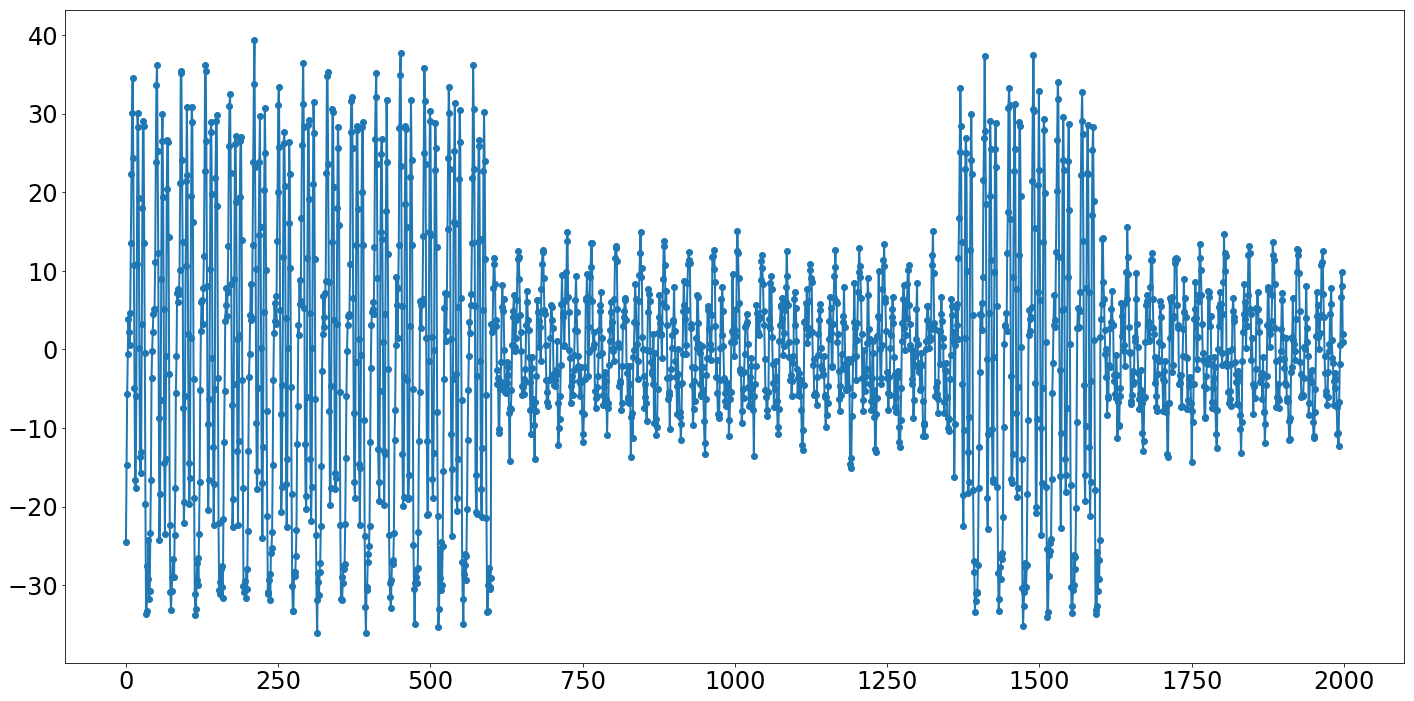

In [884]:
_ = plt.plot(X_test[0], '-o')

In [943]:
# dataframe = pd.DataFrame(X_test[0])
# dataframe.to_csv('./SyntheticData/2_patern.csv', index = False)

In [886]:
def return_h(input, i, l = 10):
    return np.sum(input[:, i:i+l, :], axis = -1)

def return_phase_track(input, l = 10):
    """
    input has a shape [batch_size, time_len, 1]
    """

    phase_track = np.zeros([input.shape[0], input.shape[1] - l, l])
    
    for i in range(0, input.shape[1] - l):
        phase_track[:, i, :] = return_h(input, i, l)
    
    return phase_track
    
    

Код для сломаной трости

In [887]:
# ramp = lambda u: np.maximum( u, 0 )
# step = lambda u: ( u > 0 ).astype(float)

# def SegmentedLinearReg( X, Y, breakpoints ):
#     nIterationMax = 200

#     breakpoints = np.sort( np.array(breakpoints) )

#     dt = np.min( np.diff(X) )
#     ones = np.ones_like(X)

#     for i in range( nIterationMax ):
#         # Linear regression:  solve A*p = Y
#         Rk = [ramp( X - xk ) for xk in breakpoints ]
#         Sk = [step( X - xk ) for xk in breakpoints ]
#         A = np.array([ ones, X ] + Rk + Sk )
#         p =  np.linalg.lstsq(A.transpose(), Y, rcond=None)[0] 

#         # Parameters identification:
#         a, b = p[0:2]
#         ck = p[ 2:2+len(breakpoints) ]
#         dk = p[ 2+len(breakpoints): ]

#         # Estimation of the next break-points:
#         newBreakpoints = breakpoints - dk/ck 

#         # Stop condition
#         if np.max(np.abs(newBreakpoints - breakpoints)) < dt/5:
#             break

#         breakpoints = newBreakpoints
#     else:
#         print( 'maximum iteration reached' )

#     # Compute the final segmented fit:
#     Xsolution = np.insert( np.append( breakpoints, max(X) ), 0, min(X) )
#     ones =  np.ones_like(Xsolution) 
#     Rk = [ c*ramp( Xsolution - x0 ) for x0, c in zip(breakpoints, ck) ]

#     Ysolution = a*ones + b*Xsolution + np.sum( Rk, axis=0 )
#     return Xsolution, Ysolution, breakpoints

In [888]:
T = 20

In [889]:
res = return_phase_track(X_test, T)

In [890]:
res.shape

(1, 1980, 20)

In [891]:
List_of_point = []
List_of_x = []
List_of_s = []
List_of_u = []
List_of_v = []

for n in tqdm(range(T, res[0].shape[0], 1)):
    if n-T > 0:
        arr = res[0][n-T:n]
    else:
        arr = res[0][:n]
        
    u, s, v = np.linalg.svd(arr)
    x = np.array(np.arange(0, s.shape[0], 1), dtype=float)
    y = np.array(s[::-1])

    List_of_x.append(n)
    
    List_of_s.append(s)
    List_of_u.append(u)
    List_of_v.append(v)
    

In [892]:
List_of_s = np.array(List_of_s)
List_of_u = np.array(List_of_u)
List_of_v = np.array(List_of_v)
List_of_x = np.array(List_of_x)

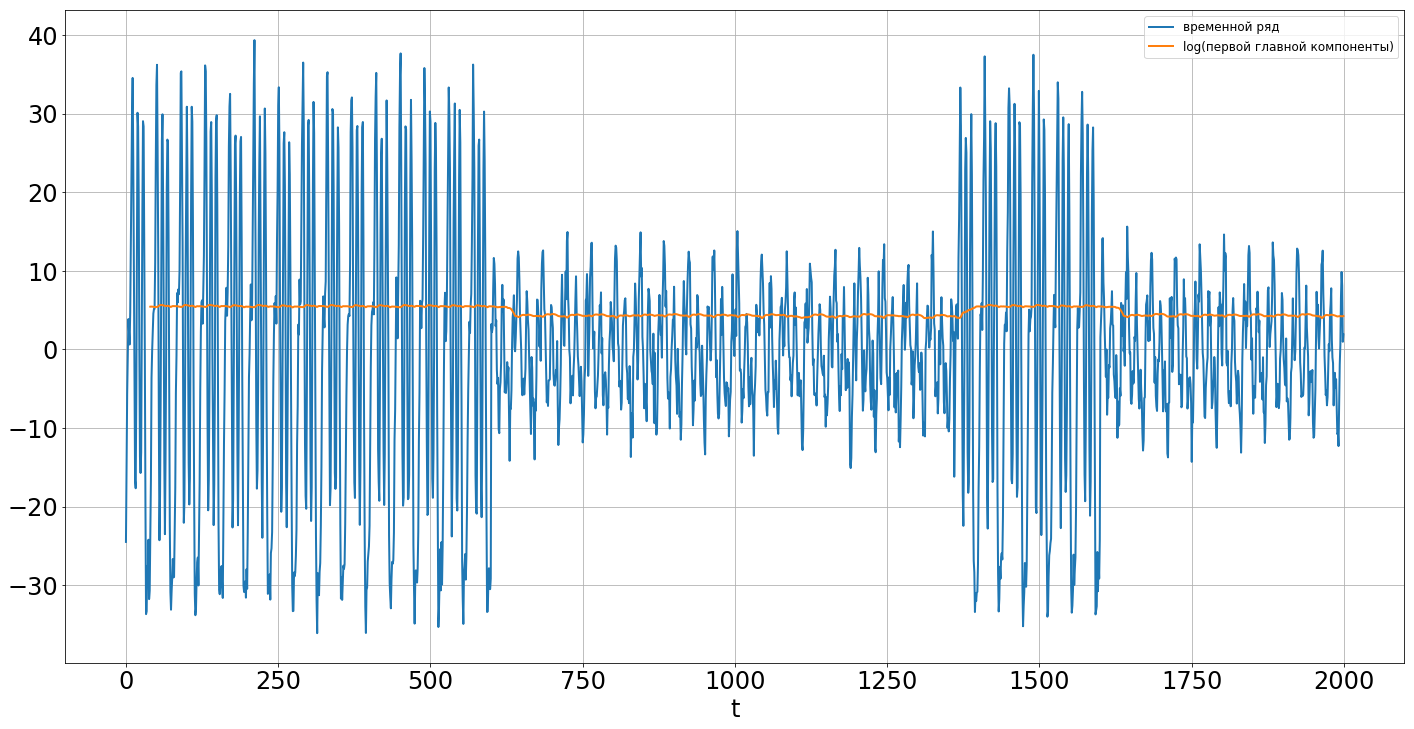

In [893]:
plt.plot(X_test[0], '-', label = 'временной ряд')
plt.plot(List_of_x+T, np.log(List_of_s[:,0]), '-', label = 'log(первой главной компоненты)')

plt.grid()
plt.xlabel('t')
plt.legend(loc = 'best')
plt.show()

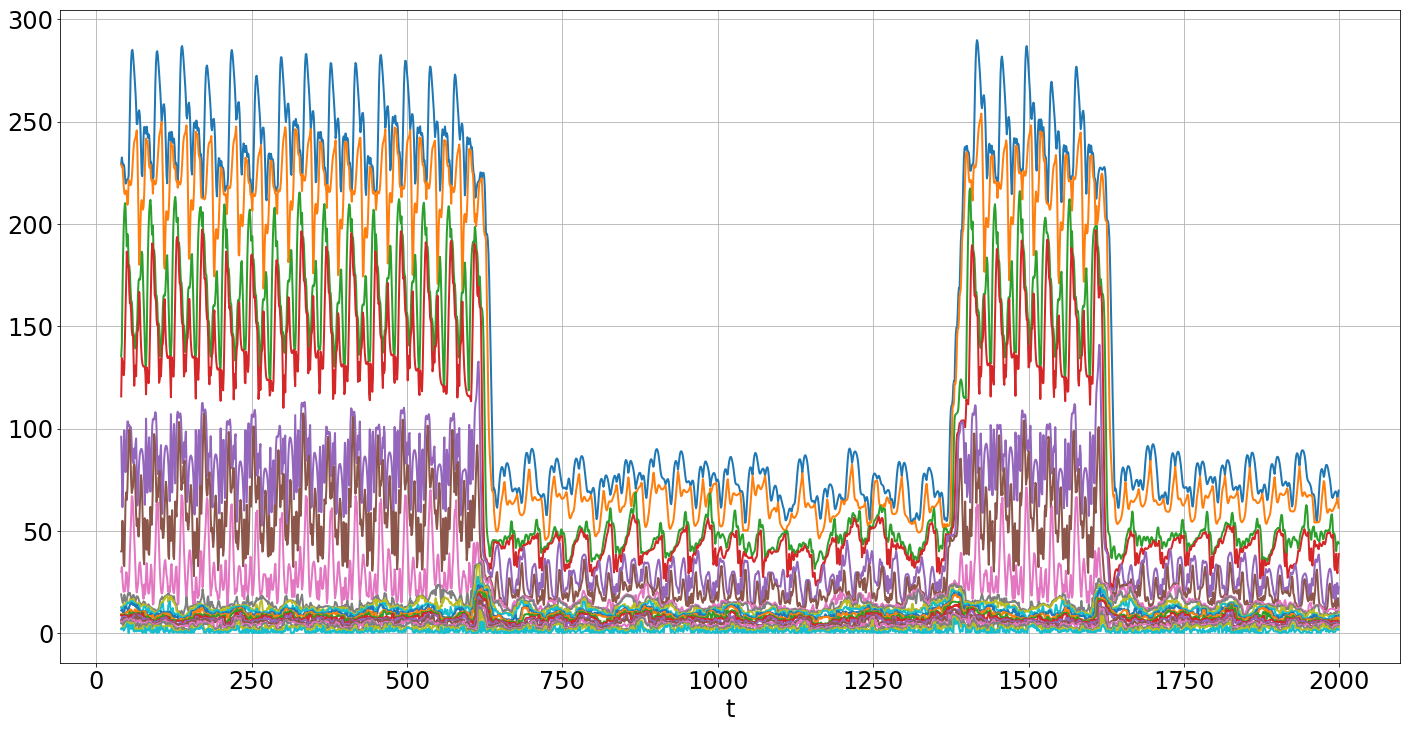

In [894]:
_ = plt.plot(List_of_x+T, List_of_s[:,:], '-')


plt.grid()
plt.xlabel('t')
plt.show()

In [895]:
# model_pca = PCA(n_components=20)
# result_pca_1 = model_pca.fit_transform(res[0])

In [896]:
result_pca_1 = res[0]

In [897]:
res[0].shape

(1980, 20)

In [898]:
result_pca_1.shape

(1980, 20)

In [899]:
List_of_basis_vector = []
List_of_basis_vector_s = []
List_of_basis_vector_c = []

model_pca = PCA(n_components=2)

for n in tqdm(range(T, result_pca_1.shape[0], 1)):
    if n-2*T > 0:
        arr = result_pca_1[n-2*T:n]
    else:
        arr = result_pca_1[:n]
    
    model_pca_answ = model_pca.fit_transform(arr)
    
    List_of_basis_vector_s.append(model_pca.singular_values_)
    
    List_of_basis_vector_c.append(model_pca_answ[-1])
    List_of_basis_vector.append(model_pca.components_)


In [900]:
List_of_basis_vector = np.array(List_of_basis_vector)
List_of_basis_vector_s = np.array(List_of_basis_vector_s)
List_of_basis_vector_c = np.array(List_of_basis_vector_c)


In [901]:
List_of_basis_vector.shape

(1960, 2, 20)

In [902]:
Volum = np.zeros([2, List_of_basis_vector.shape[0], List_of_basis_vector.shape[0]])


In [903]:
cos_beta = np.abs(List_of_basis_vector[:, 0, :]@List_of_basis_vector[:, 1, :].T)
cos_alpha = np.array(np.diagonal(cos_beta))
cos_gamma = np.abs(List_of_basis_vector[:, 1, :]@List_of_basis_vector[:, 1, :].T)


In [904]:
cos_beta[np.where(cos_beta > 1-10**(-10))] = 1-10**(-10)
cos_alpha[np.where(cos_alpha > 1-10**(-10))] = 1-10**(-10)
cos_gamma[np.where(cos_gamma > 1-10**(-10))] = 1-10**(-10)

In [905]:
cos_beta[np.where(cos_beta < 10**(-10))] = 0
cos_alpha[np.where(cos_alpha < 10**(-10))] = 0
cos_gamma[np.where(cos_gamma < 10**(-10))] = 0

In [906]:
temp_a = np.sqrt(1-cos_beta**2)
cos_A = np.abs((cos_alpha.reshape([-1,1]) - cos_gamma*cos_beta)/(np.sqrt(1-cos_gamma**2)*np.sqrt(1-cos_beta**2)))
h = temp_a*np.sqrt(1-cos_A**2)

Volum[0] = h* np.sqrt(1-cos_gamma**2)
        
        

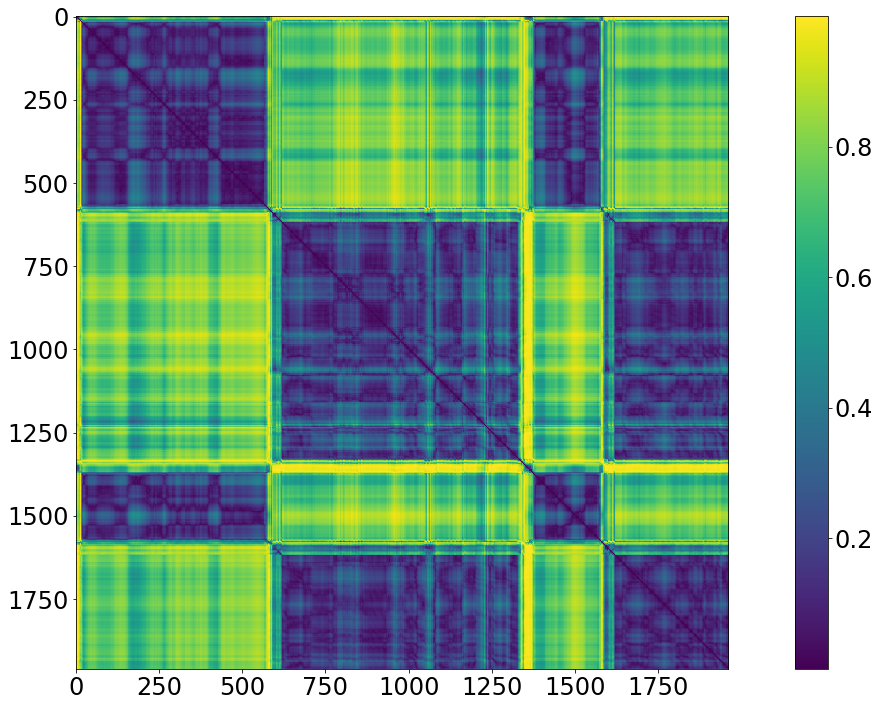

In [907]:
_ = plt.imshow(Volum[0])

_ = plt.colorbar()

In [908]:
cos_beta = np.abs(List_of_basis_vector[:, 0, :]@List_of_basis_vector[:, 0, :].T)
cos_gamma = np.abs(List_of_basis_vector[:, 1, :]@List_of_basis_vector[:, 0, :].T)

cos_alpha = np.array(np.diagonal(cos_gamma))


In [909]:
cos_beta[np.where(cos_beta > 1-10**(-10))] = 1-10**(-10)
cos_alpha[np.where(cos_alpha > 1-10**(-10))] = 1-10**(-10)
cos_gamma[np.where(cos_gamma > 1-10**(-10))] = 1-10**(-10)

In [910]:
cos_beta[np.where(cos_beta < 10**(-10))] = 0
cos_alpha[np.where(cos_alpha < 10**(-10))] = 0
cos_gamma[np.where(cos_gamma < 10**(-10))] = 0

In [911]:
temp_a = np.sqrt(1-cos_beta**2)
cos_A = (cos_alpha.reshape([-1,1]) - cos_gamma*cos_beta)/(np.sqrt(1-cos_gamma**2)*np.sqrt(1-cos_beta**2))
h = temp_a*np.sqrt(1-cos_A**2)

Volum[1] = h* np.sqrt(1-cos_gamma**2)
        

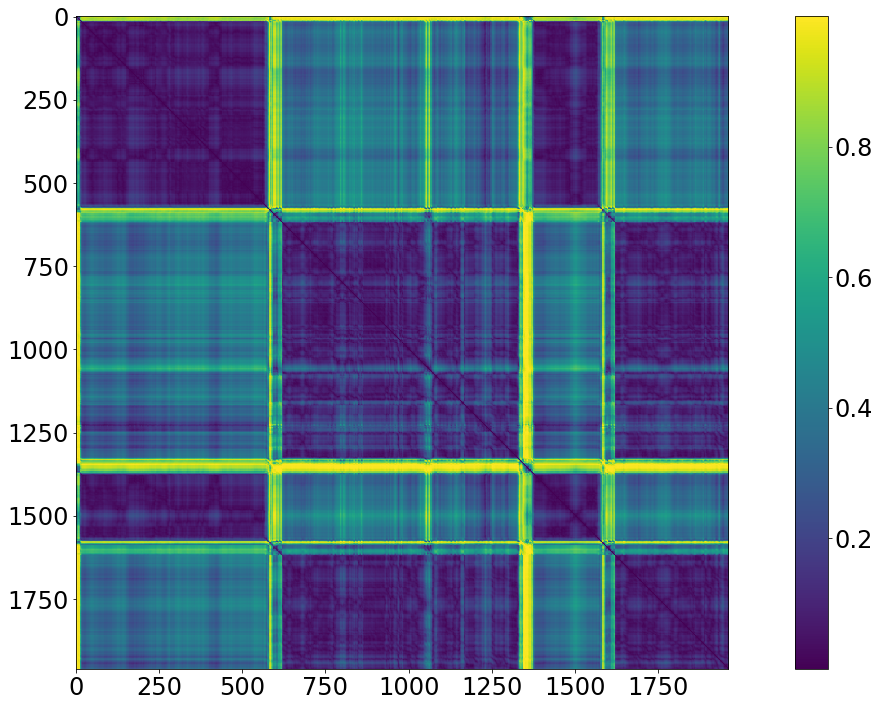

In [912]:
_ = plt.imshow(Volum[1])

_ = plt.colorbar()

In [913]:
vol = np.max(Volum, axis = 0)

In [914]:
vol.shape

(1960, 1960)

In [915]:
for i in tqdm(range(vol.shape[0])):
    for j in range(vol.shape[0]):
        vol[i,j] = max(vol[i,j], vol[j,i])

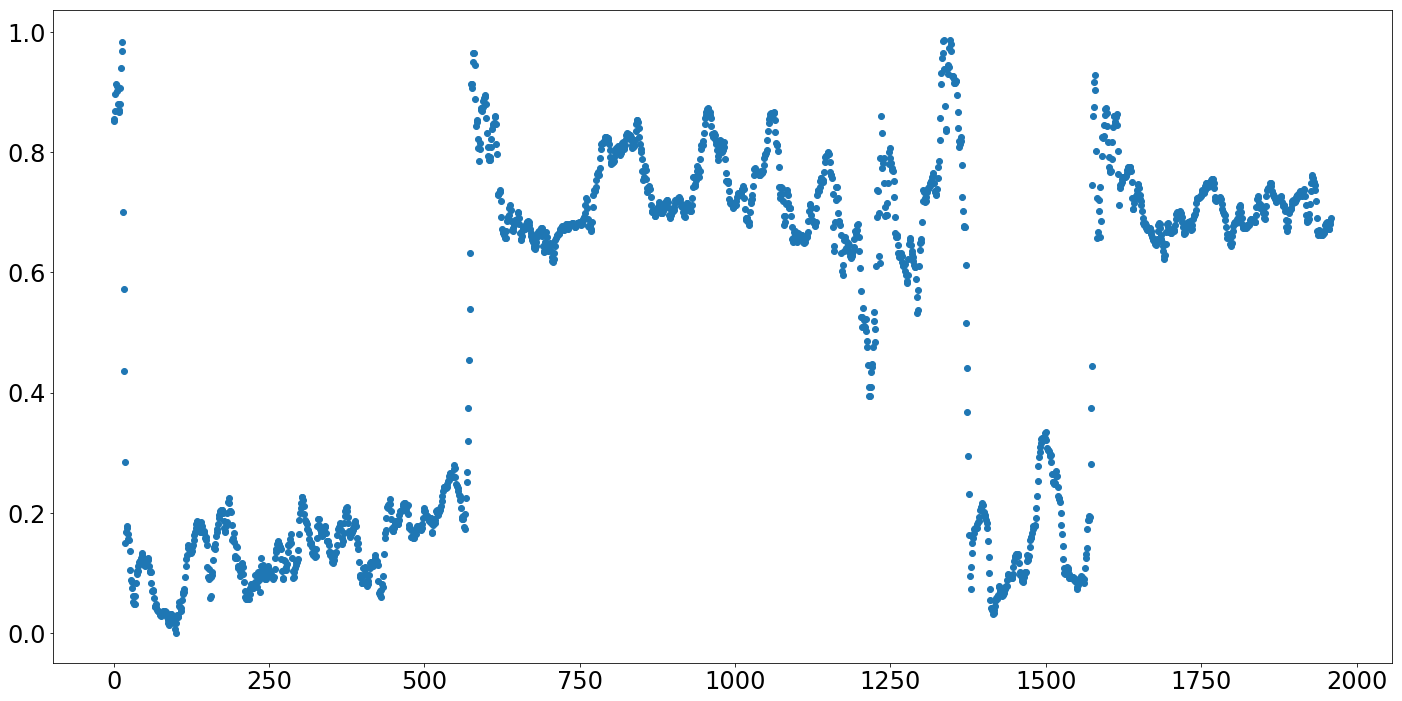

In [916]:
_ = plt.plot(vol[100], 'o')

In [917]:
vol.shape

(1960, 1960)

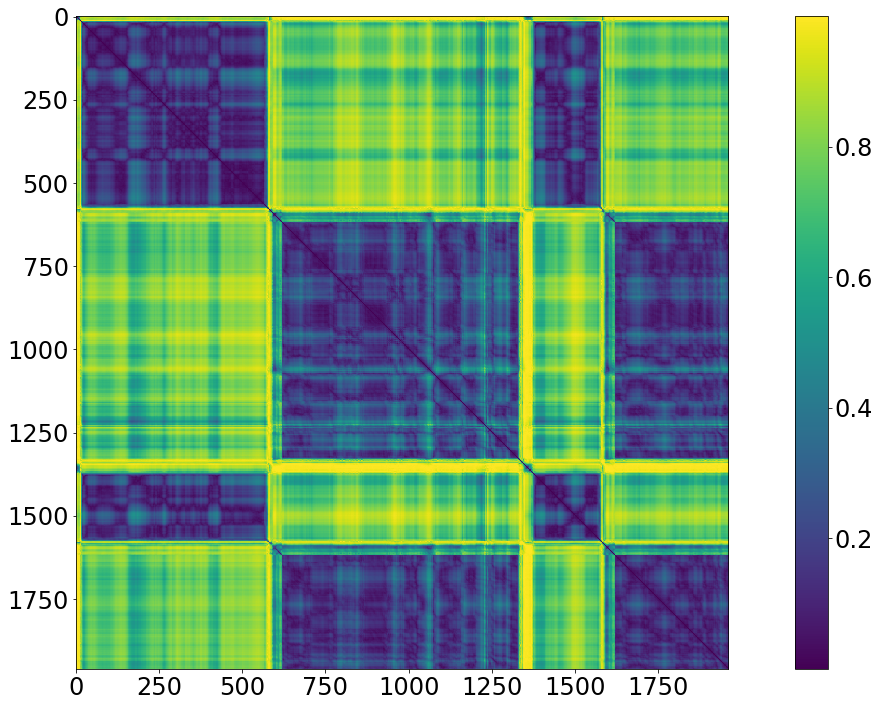

In [918]:
_ = plt.imshow(vol)

_ = plt.colorbar()


In [919]:
from sklearn.cluster import KMeans


In [920]:
model = KMeans(n_clusters=2)
model.fit(List_of_s)
prediction_value = model.predict(List_of_s)

In [921]:
prediction_value.shape

(1960,)

In [922]:
from sklearn.manifold import MDS

In [923]:
embedding = MDS(n_components=2, dissimilarity='precomputed')

In [924]:
resss = embedding.fit_transform(vol)

In [925]:
model = KMeans(2)
fitted = model.fit(resss)
prediction_vector = fitted.fit_predict(resss)

In [926]:
resss.shape

(1960, 2)

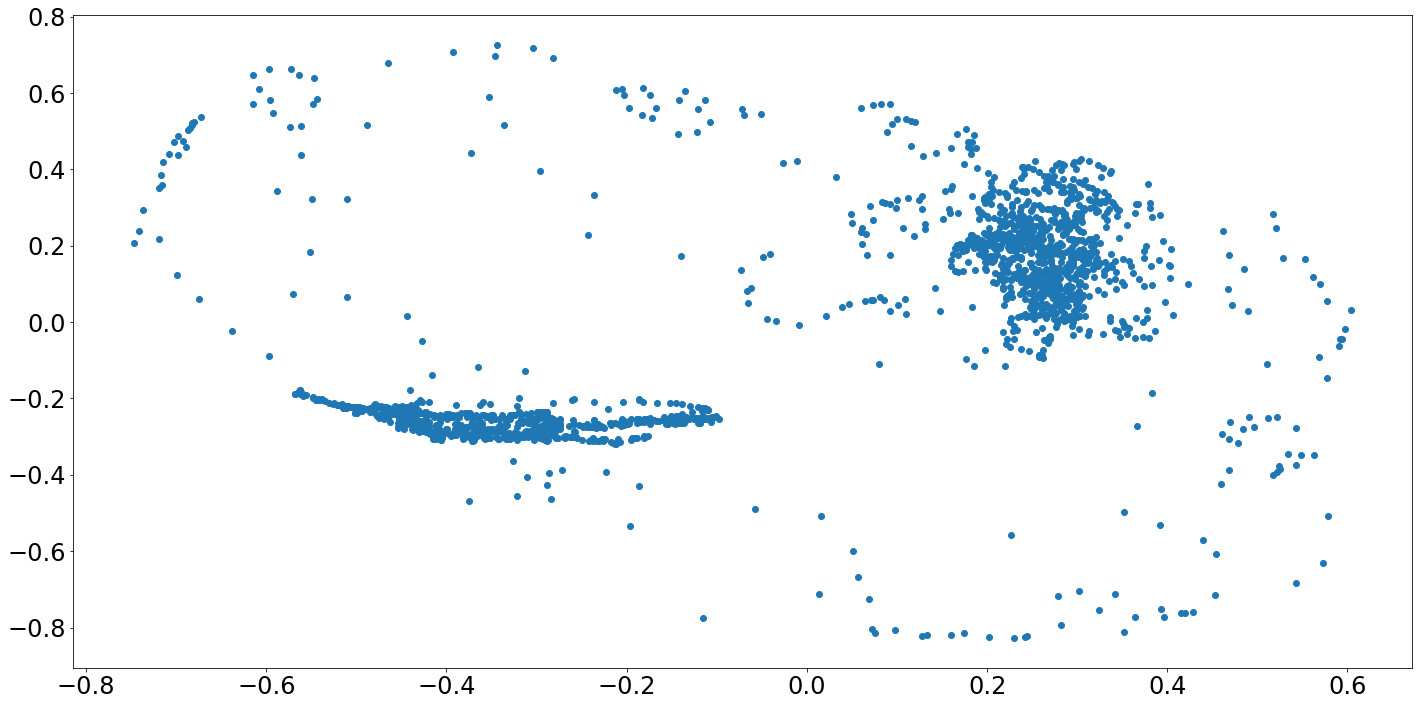

In [927]:
_ = plt.plot(resss[:,0], resss[:, 1], 'o')


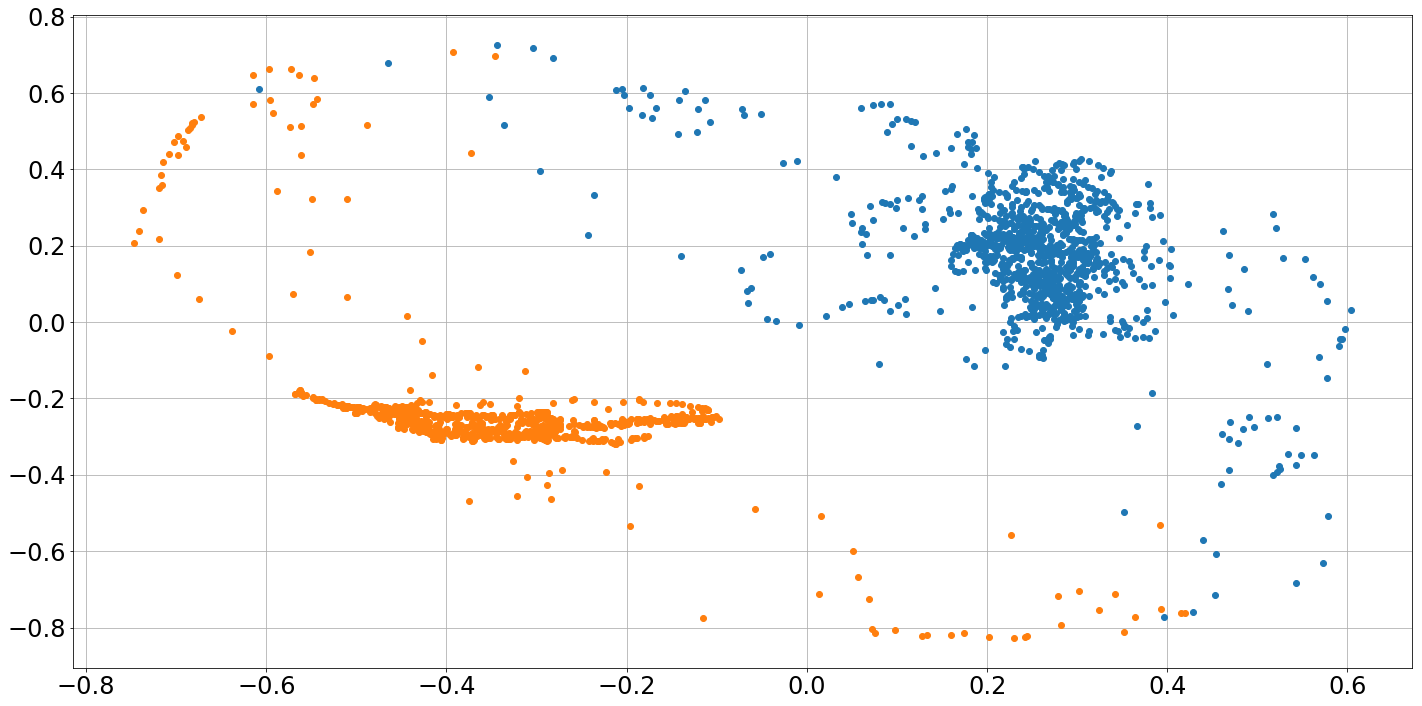

In [928]:
for t in np.unique(prediction_value):
    ind = np.where(prediction_value == t)
    _ = plt.plot(resss[:, 0][ind], resss[:, 1][ind], 'o')

plt.grid()
plt.show()

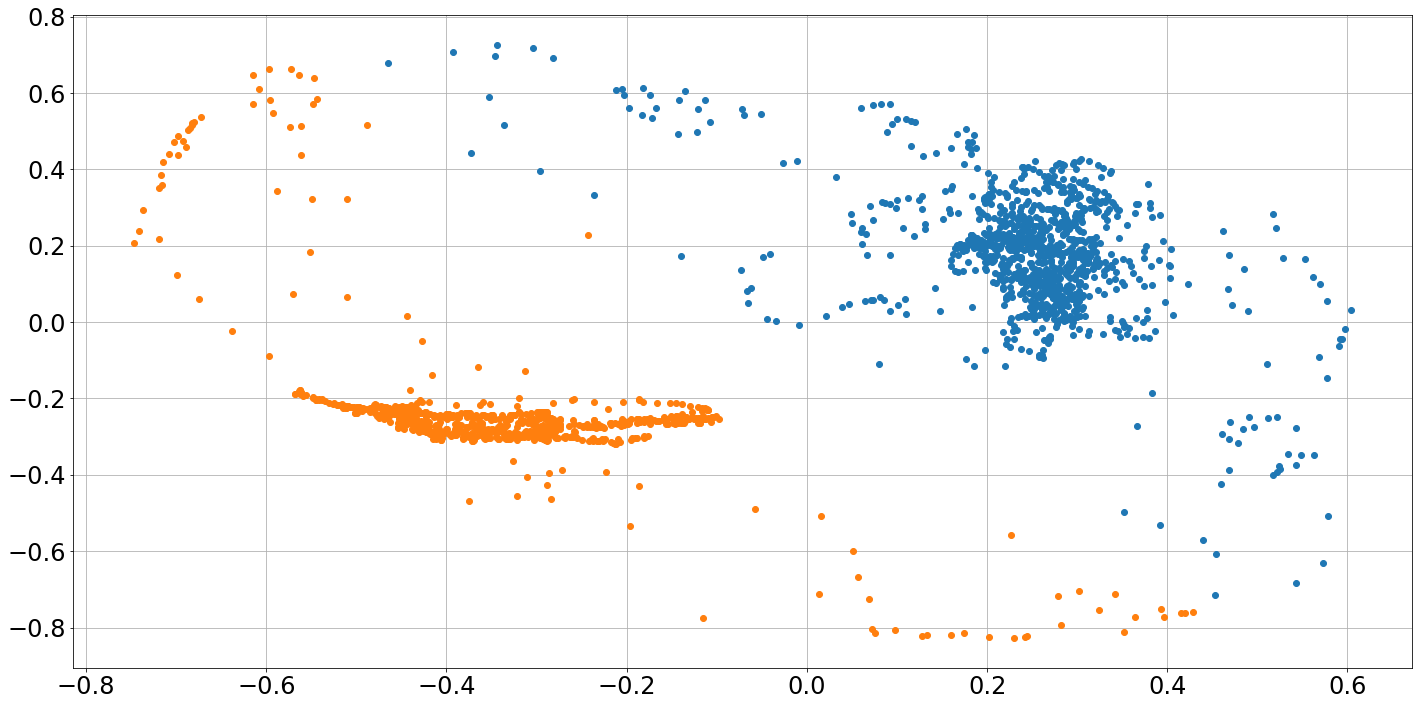

In [929]:
for t in np.unique(prediction_vector):
    ind = np.where(prediction_vector == t)
    _ = plt.plot(resss[:, 0][ind], resss[:, 1][ind], 'o')


plt.grid()
plt.show()

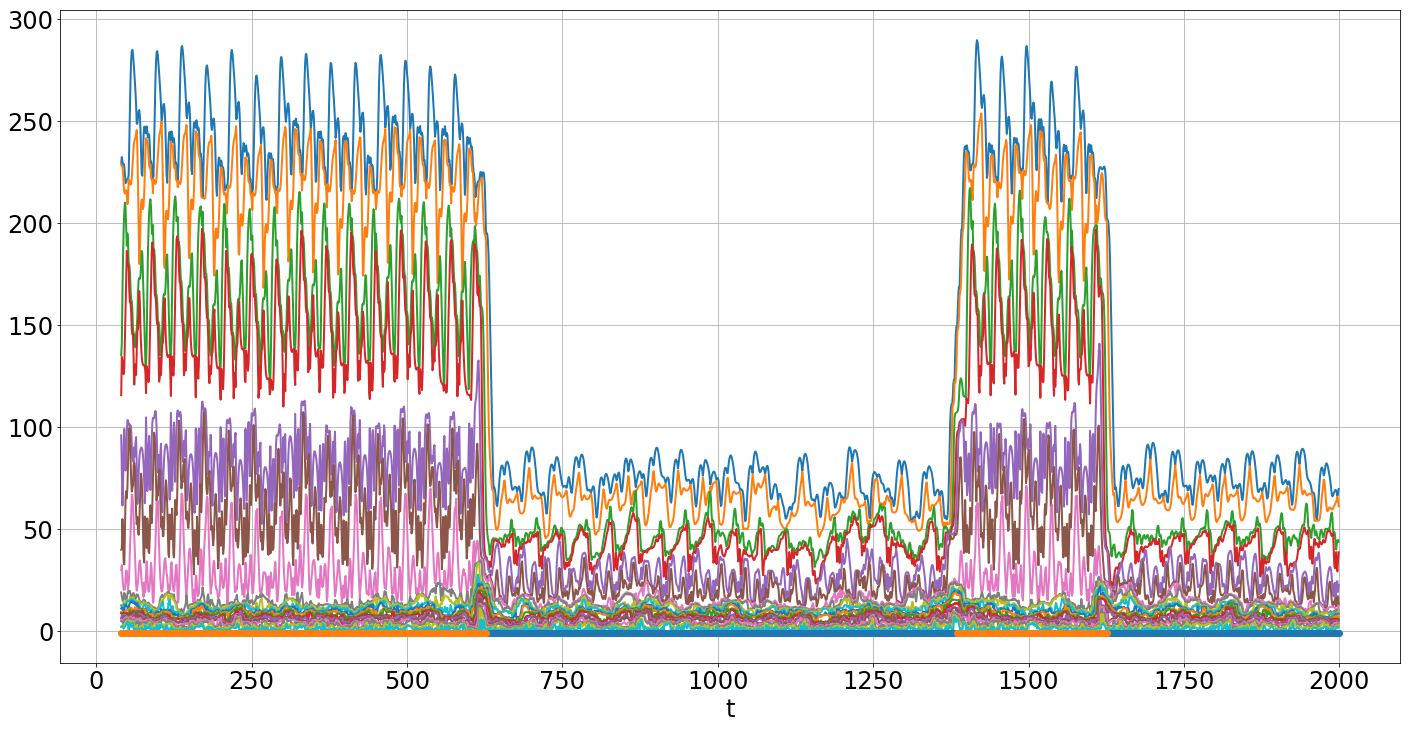

In [930]:
_ = plt.plot(List_of_x+T, List_of_s[:,:], '-')

line = -np.ones_like(List_of_x)

for t in np.unique(prediction_value):
    ind = np.where(prediction_value == t)
    _ = plt.plot(List_of_x[ind]+T, line[ind], 'o')


plt.grid()
plt.xlabel('t')
plt.show()

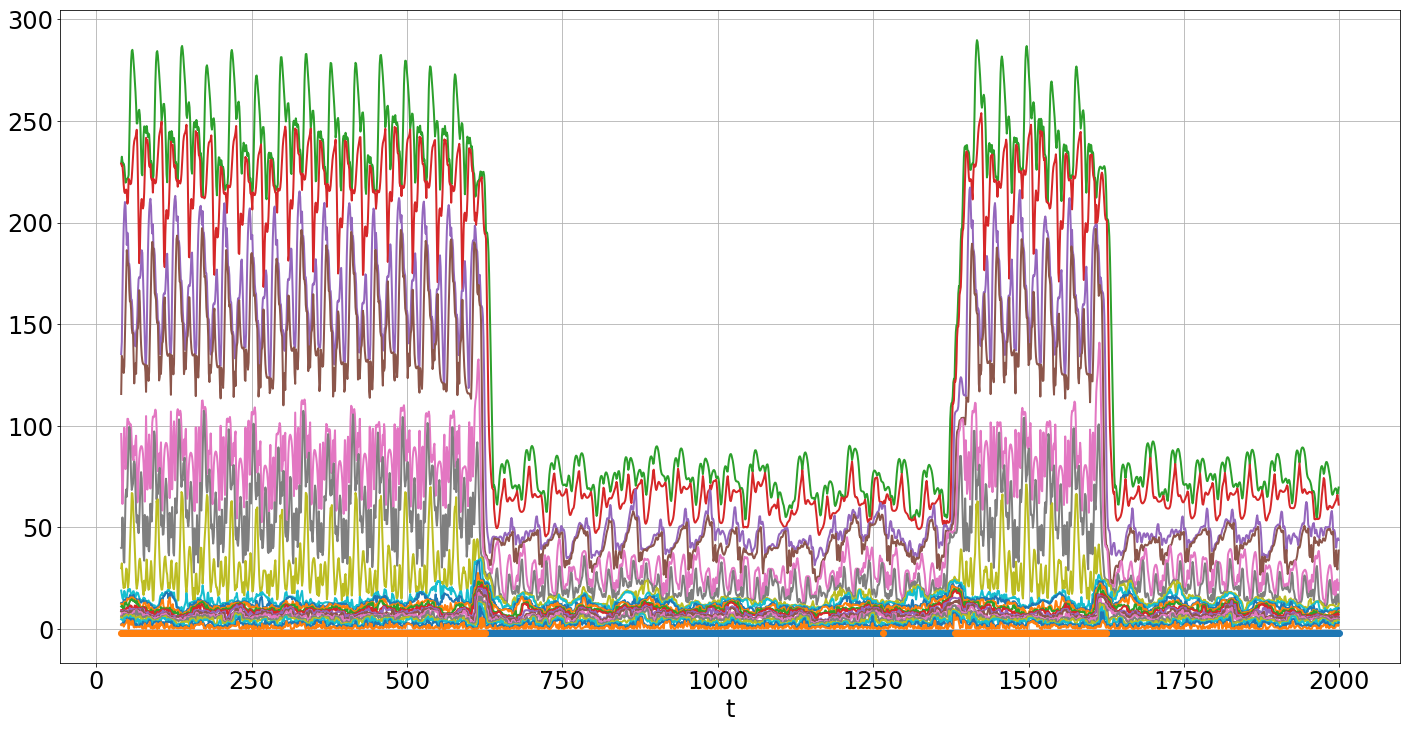

In [931]:
line = -2*np.ones_like(List_of_x)

for t in np.unique(prediction_vector):
    ind = np.where(prediction_vector == t)
    _ = plt.plot(List_of_x[ind]+T, line[ind], 'o')

_ = plt.plot(List_of_x+T, List_of_s[:,:], '-')



plt.grid()
plt.xlabel('t')
plt.show()

In [932]:
model_pca = PCA(n_components=2)
result_pca = model_pca.fit_transform(result_pca_1)

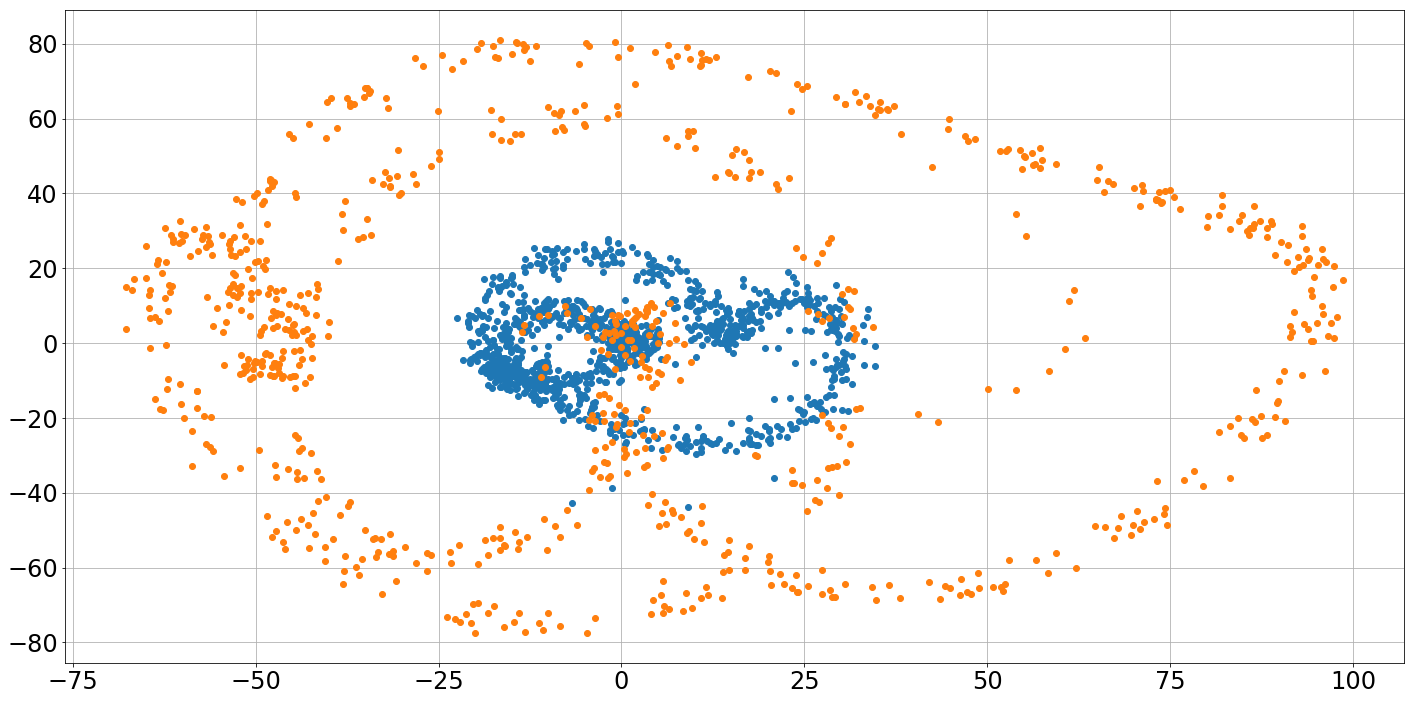

In [933]:
for t in np.unique(prediction_value):
    ind = np.where(prediction_value == t)
    _ = plt.plot(result_pca[T:, 0][ind], result_pca[T:, 1][ind], 'o')

plt.grid()
plt.show()

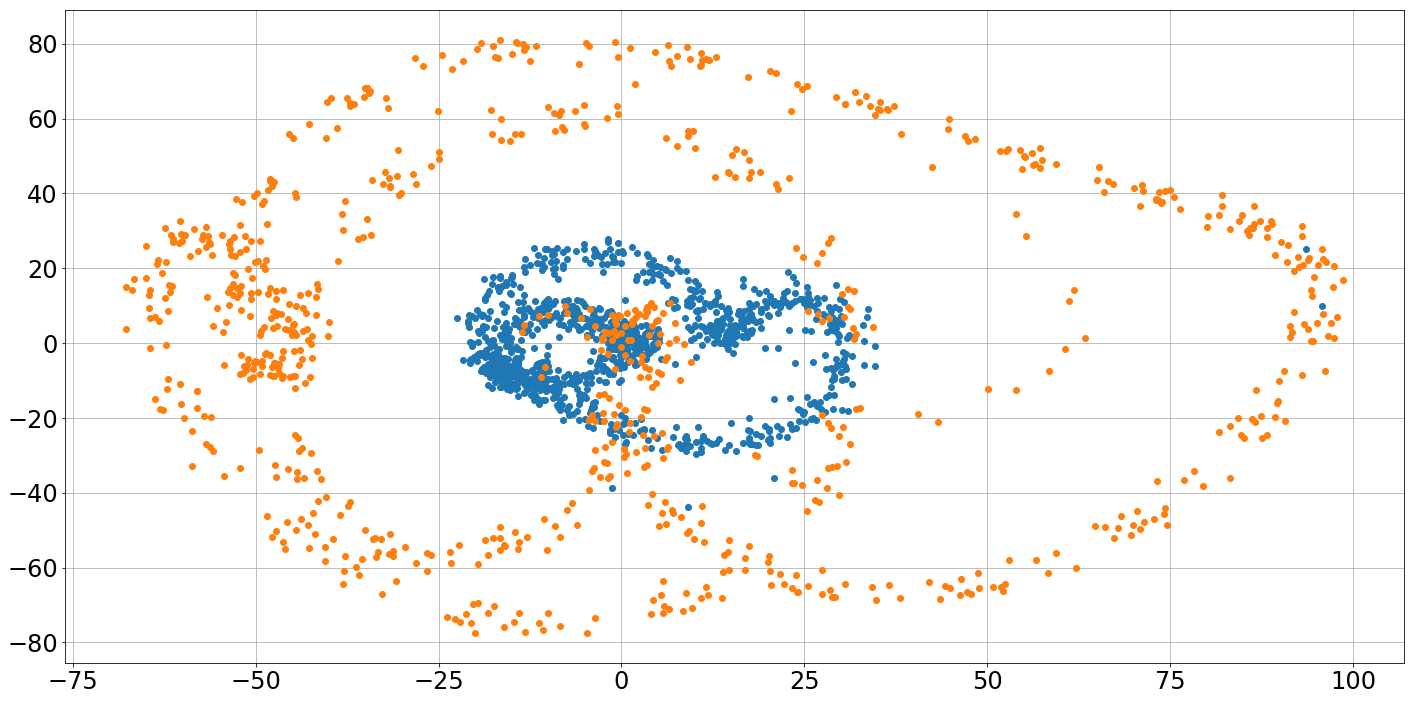

In [934]:
for t in np.unique(prediction_vector):
    ind = np.where(prediction_vector == t)
    _ = plt.plot(result_pca[T:, 0][ind], result_pca[T:, 1][ind], 'o')

plt.grid()
plt.show()

In [935]:
result_pca.shape

(1980, 2)

In [936]:
rho = np.sqrt((result_pca**2).sum(axis = 1))

In [937]:
phi = np.arctan2(result_pca[:,0], result_pca[:,1])

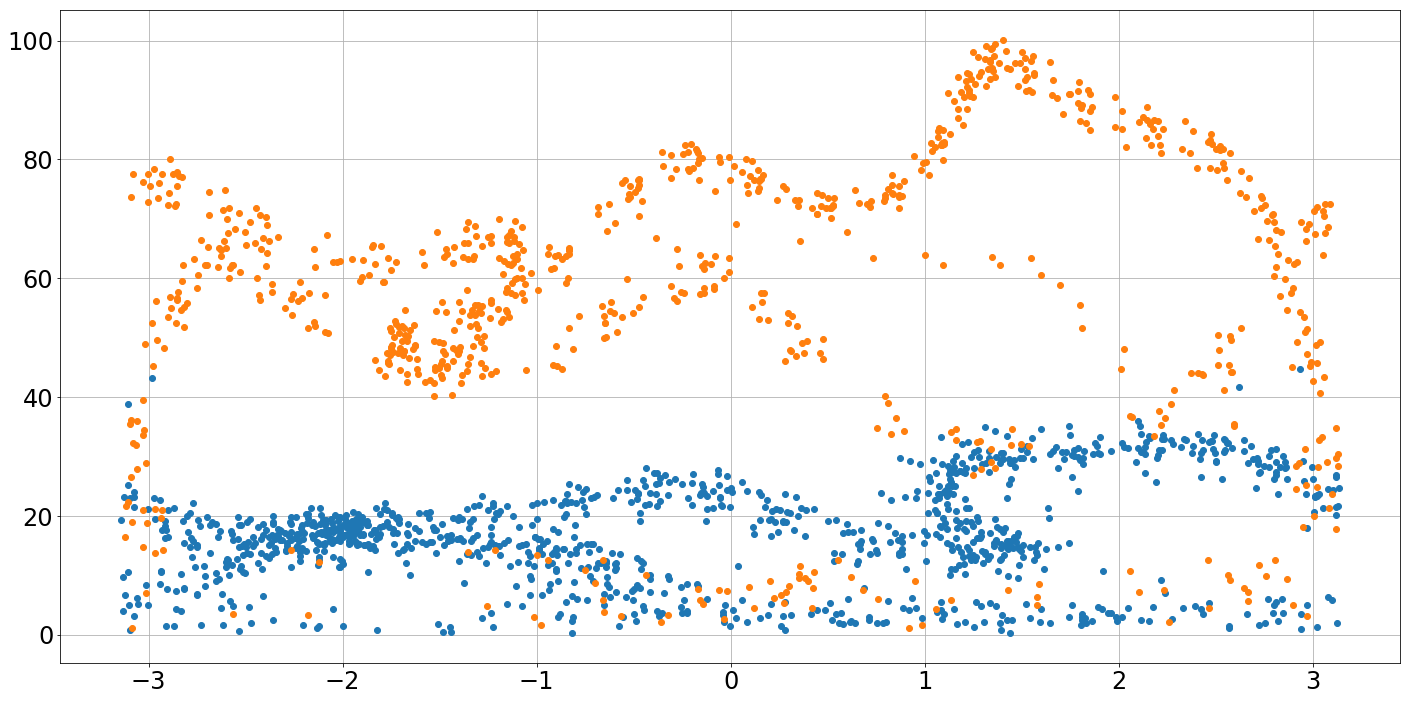

In [938]:
for t in np.unique(prediction_value):
    ind = np.where(prediction_value == t)
    _ = plt.plot(phi[T:][ind], rho[T:][ind], 'o')


plt.grid()
plt.show()

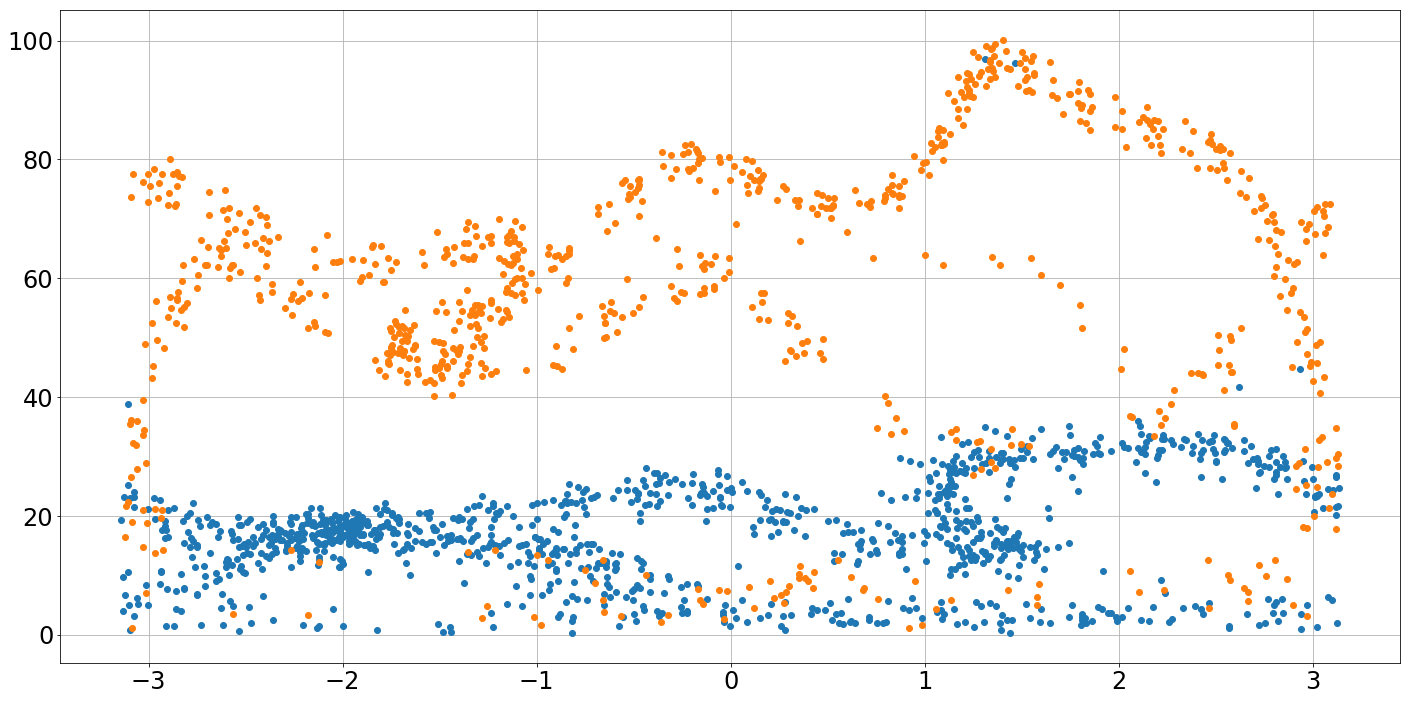

In [939]:
for t in np.unique(prediction_vector):
    ind = np.where(prediction_vector == t)
    _ = plt.plot(phi[T:][ind], rho[T:][ind], 'o')


plt.grid()
plt.show()

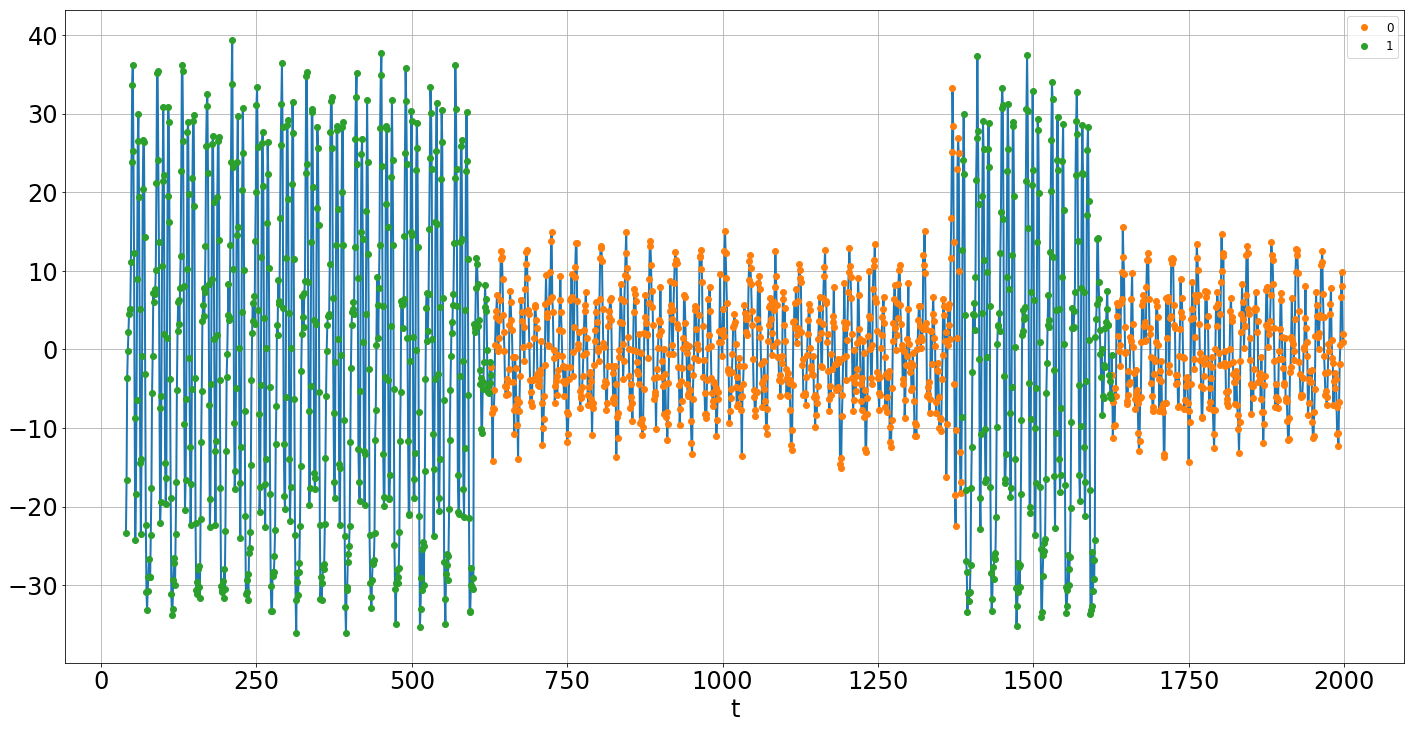

In [942]:
_ = plt.plot(List_of_x+T, X_test[0][2*T:], '-')

for t in np.unique(prediction_value):
    ind = np.where(prediction_value == t)
    _ = plt.plot(List_of_x[ind]+T, X_test[0][2*T:][ind], 'o', label = str(t))




plt.grid()
plt.legend(loc = 'best')
plt.xlabel('t')
plt.show()

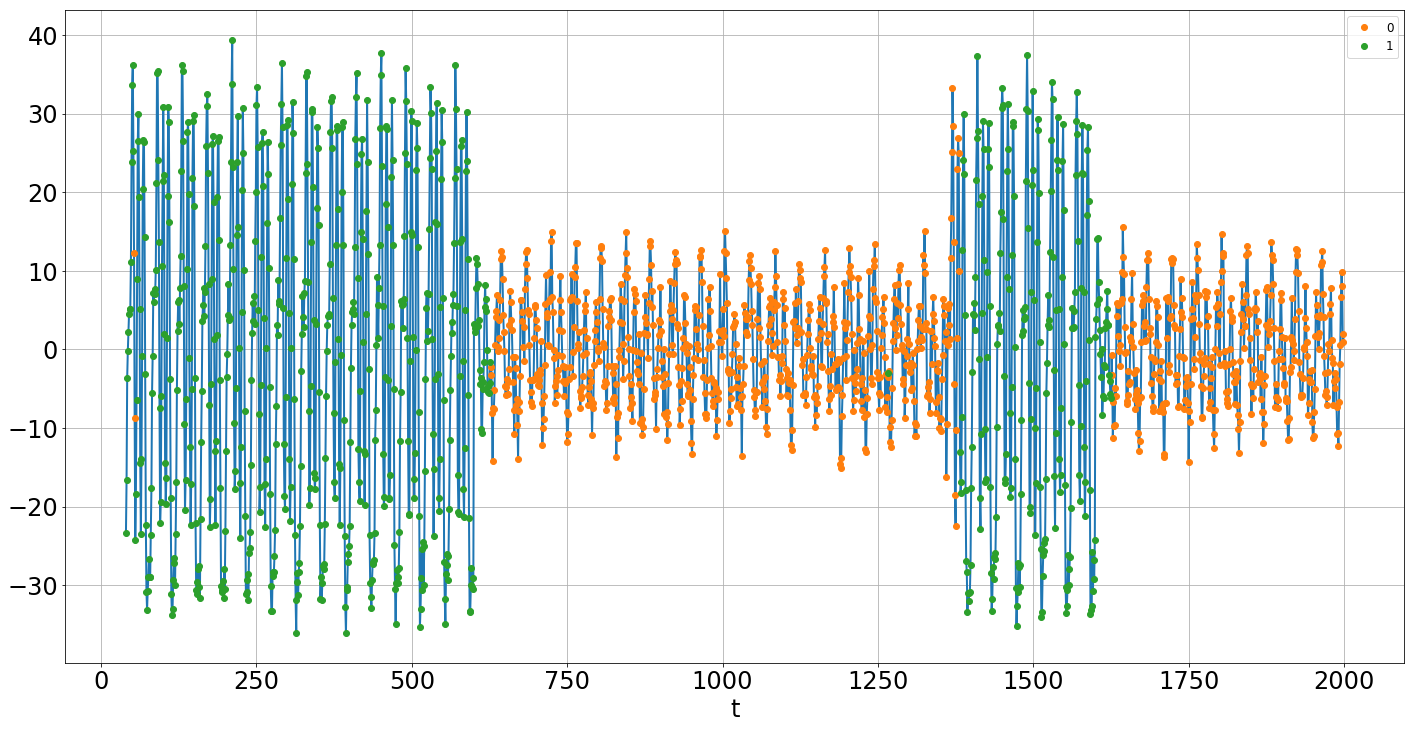

In [941]:
_ = plt.plot(List_of_x+T, X_test[0][2*T:], '-')

for t in np.unique(prediction_vector):
    ind = np.where(prediction_vector == t)
    _ = plt.plot(List_of_x[ind]+T, X_test[0][2*T:][ind], 'o', label = str(t))



plt.grid()
plt.legend(loc = 'best')
plt.xlabel('t')
plt.show()